In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import os
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import ToTensor, Compose, ConvertImageDtype
import torch.nn.functional as F

from Data_manager import SegmentationDataset, collate_fn

In [2]:
print(torch.version.cuda)

12.9


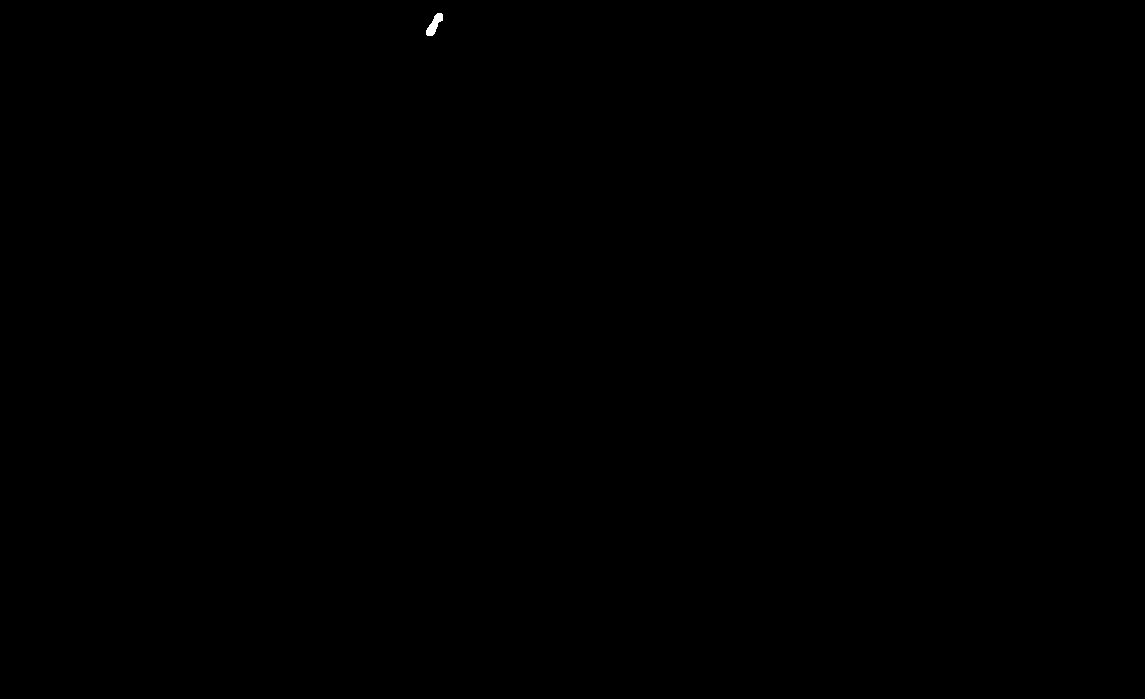

In [3]:
mask = Image.open('data/Hesperidine_u87m6_5_g_neg/u87m6_5_k_g/labels/7.png')
mask.show()

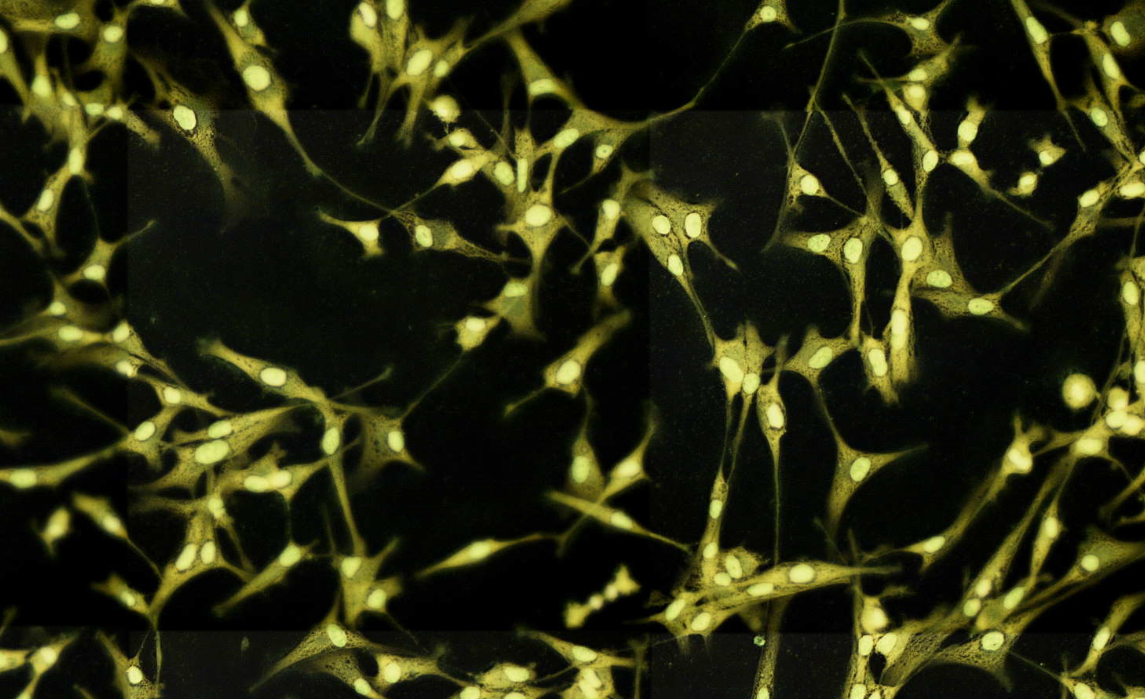

In [4]:
image = Image.open('data/Hesperidine_u87m6_5_g_neg/u87m6_5_k_g6.tif')
image.show()

In [5]:
train_root_dir = 'data/Hesperidine_u87m6_5_g_neg'
train_dataset = SegmentationDataset(train_root_dir)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=False, collate_fn = collate_fn)

In [6]:
device = 'cuda'
num_epochs = 10
num_classes = 3
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=hidden_layer, dim_reduced=hidden_layer, num_classes=num_classes)

model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [7]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, targets = batch
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Обучение
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
    
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")  

In [ ]:
torch.save(model.state_dict(), 'test_mask_rcnn.pth')
print("Модель сохранена как test_mask_rcnn.pth")